In [1]:
#Upload kml file
from pykml import parser
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial import KDTree

with open('../Resources/glims_polygons.kml', 'r', encoding="utf-8") as f:
   root = parser.parse(f).getroot()
#Put kml to dataframe  
places = []
for place in root.Document.Folder.Placemark:
    data = {item.get("name"): item.text for item in
            place.ExtendedData.SchemaData.SimpleData}
    coords = place.Polygon.outerBoundaryIs.LinearRing.coordinates.text.strip()
    data["Coordinates"] = coords
    places.append(data)
df = pd.DataFrame(places)
# print(df)

In [2]:
# df.head()

In [3]:
# df.dtypes

In [4]:
cleaned_df = df[['line_type','anlys_id','area','glac_id','anlys_time','db_area','min_elev','mean_elev','max_elev','primeclass','Coordinates','src_date','rec_status','glac_name','glac_stat',
'gone_date','gone_dt_e','subm_id','release_dt','proc_desc','rc_id','geog_area','conn_lvl','surge_type','term_type','gtng_o1reg','gtng_o2reg',
'rgi_gl_typ','loc_unc_x','glob_unc_y']]

# Counting initial number of rows to make sure we don't somehow lose any.
row_count = cleaned_df.shape[0]
print(f"Number of rows: {row_count}")

Number of rows: 69572


In [5]:
# cleaned_df.head()

In [6]:
# Dictionary to store unique values DataFrames
unique_dfs = {}

# Iterate over each column, get unique values, and create DataFrame
for column in cleaned_df.columns:
    unique_values = cleaned_df[column].unique()
    unique_dfs[column] = pd.DataFrame(unique_values, columns=[f'unique_{column}'])

# for column, unique_df in unique_dfs.items():
#     print(f"Unique values in {column} as DataFrame:")
#     print(unique_df)
#     print()

In [7]:
unique_glac_name = 'glac_name'
glac_name_df = unique_dfs.get(unique_glac_name)

glac_name_df.to_csv('../Resources/glac_name_df.csv', index=False)

In [8]:
# SEE ABOVE FOR DEFINITIONS. ELIMINATING PRIMECLASS, REC_STATUS, SUBM_ID, GONE_DT_E, PROC_DESC, RC_ID, GEOG_AREA, CONN_LVL, SURGE_TYPE, TERM_TYPE, GTNG_O1REG, GTNG_O2REG, RGI_GL_TYP,
# LOC_UNC_X, GLOB_UNC_Y

# SOME ARE NOTES, SOME ARE DEFINITIONS RELEVANT TO SOMEONE. LIKELY NOT TO US. REC_STATUS HAD ONE VALUE; 'OKAY'.

cleaned_df_2 = df[['line_type','anlys_id','area','glac_id','anlys_time','db_area','min_elev','mean_elev','max_elev','Coordinates','src_date','glac_name','glac_stat',
'gone_date','release_dt']]

In [9]:
# making a df copy
cleaned_df_3 = cleaned_df_2.copy()

# glac_stat has two unique values. replaced exists with e and gone with g
cleaned_df_3['glac_stat'] = cleaned_df_3['glac_stat'].replace({'gone': 'g', 'exists': 'e'})

# line_type has three unique values. Replaced debris_cov with dc, glac_bound with gb, intrnl_rock with ir
cleaned_df_3['line_type'] = cleaned_df_3['line_type'].replace({'debris_cov': 'dc', 'glac_bound': 'gb', 'intrnl_rock': 'ir'})

In [10]:
# Changed the times which were strings to times that are datetime objects. Took away the hour and rounded off to a day, which
# wasn't intentional, but we don't need hourly resolution for a measurement of an object that changes very slowly
# and that we are only seeing measurements for a few times per year at most

cleaned_df_3['src_date'] = pd.to_datetime(cleaned_df_3['src_date'])
cleaned_df_3['anlys_time'] = pd.to_datetime(cleaned_df_3['anlys_time'])
cleaned_df_3['release_dt'] = pd.to_datetime(cleaned_df_3['release_dt'])


# Converted the times to unix. Unix times before 1/1/1970 are negative numbers, descending from 0 below 1/1/1970, so they'll still work and be
# convertible and comparable.
# Of note, minimum recording is 12/13/1901, so if there were dates before that, this would not be feasible.

cleaned_df_3['src_date'] = cleaned_df_3['src_date'].apply(lambda x: int(x.timestamp()))
cleaned_df_3['anlys_time'] = cleaned_df_3['anlys_time'].apply(lambda x: int(x.timestamp()))
cleaned_df_3['release_dt'] = cleaned_df_3['release_dt'].apply(lambda x: int(x.timestamp()))

# format for gone_date. the object wasn't recognized as a time like the other was, so I explicitly defined the format.
gone_date_raw_format = '%Y-%m-%d'

# Converting gone_date to datetime.
cleaned_df_3['gone_date'] = pd.to_datetime(cleaned_df_3['gone_date'], format=gone_date_raw_format, errors='coerce')

# Converting gone_date to unix. If the glacier still exists, it's a NaT, so replacing it with e for exists.
nat_replace_if_exists = 'e'
cleaned_df_3['gone_date'] = cleaned_df_3['gone_date'].apply(
    lambda x: int(x.timestamp()) if pd.notna(x) else nat_replace_if_exists
)

In [11]:
# Copying data frame

cleaned_df_4 = cleaned_df_3.copy()

# Converting columns to float. errors='coerce' won't effect 0 values, but any non-number will be converted to nan. Will print between this conversion and
# the formatting just to make sure.

cleaned_df_4['area'] = pd.to_numeric(cleaned_df_4['area'], errors='coerce')
cleaned_df_4['db_area'] = pd.to_numeric(cleaned_df_4['db_area'], errors='coerce')

nat_replace = 'x'

# nan_rows # no nan rows for either area or db_area, so we're good, per the below check.
# nan_rows = cleaned_df_4[cleaned_df_4['db_area'].isna()]

# converting to float with the trailing digits removed. The number is the number of the significant digits we round to.

for column in ['area', 'db_area']:
    cleaned_df_4[column] = cleaned_df_4[column].apply(lambda x: '{:.15g}'.format(x) if pd.notnull(x) else nat_replace)



In [12]:
# Drop the analysis ID column for cleaned_df_5. We LIKELY don't need it.

cleaned_df_5 = cleaned_df_4.drop(columns=['anlys_id'])

In [13]:
# # This is to view how many unique glac_id exist per glac_name.

# cleaned_df_6 = cleaned_df_5.copy()

# # Group by glac_name and count unique glac_id values
# glac_id_counts = cleaned_df_6.groupby('glac_name')['glac_id'].nunique().reset_index()

# # Rename columns for clarity
# glac_id_counts.columns = ['glac_name', 'unique_glac_id_count']

# glac_id_counts

In [14]:
filter_value = 'Yalik Glacier'

filtered_df_1 = cleaned_df_5[cleaned_df_5['glac_name'] == filter_value]

filtered_df_1

,line_type,area,glac_id,anlys_time,db_area,min_elev,mean_elev,max_elev,Coordinates,src_date,glac_name,glac_stat,gone_date,release_dt
36509,gb,51.73,G209221E59477N,1277856000,47.8702,0,0,0,"-150.806368,59.605433,0 -150.806899,59.605442,...",1247097600,Yalik Glacier,e,e,1292322901
46754,gb,41.538,G209221E59477N,1437004800,41.538,42,0,1552,"-150.788813,59.502486,0 -150.788775,59.502503,...",1121817600,Yalik Glacier,e,e,1437004800
58969,gb,0,G209221E59477N,1662681600,33.8425,0,0,0,"-150.839498,59.582783,0 -150.839628,59.582196,...",1472601600,Yalik Glacier,e,e,1666515600
59752,gb,0,G209221E59477N,1662681600,43.7459,0,0,0,"-150.794388,59.587185,0 -150.794436,59.587208,...",526867200,Yalik Glacier,e,e,1667206800
60794,gb,0,G209221E59477N,1662681600,40.9947,0,0,0,"-150.780429,59.510793,0 -150.780197,59.510828,...",808876800,Yalik Glacier,e,e,1667293200
62390,gb,41.538,G209221E59477N,1670630400,40.9931,42,0,1552,"-150.772762,59.501546,0 -150.772591,59.501385,...",1121817600,Yalik Glacier,e,e,1667206800
62780,gb,41.538,G209214E59534N,1670630400,0.10758,42,0,1552,"-150.771308,59.499503,0 -150.771305,59.499502,...",1121817600,Yalik Glacier,e,e,1667206800
62833,gb,41.538,G209214E59535N,1670630400,0.149888,42,0,1552,"-150.799431,59.527744,0 -150.799387,59.527108,...",1121817600,Yalik Glacier,e,e,1667206800
63723,gb,41.538,G209213E59534N,1670630400,0.126632,42,0,1552,"-150.799898,59.52772,0 -150.799946,59.527982,0...",1121817600,Yalik Glacier,e,e,1667206800


In [15]:
# We still have the same number of rows. Check the cell above that lists row count for cleaned_df
row_count = cleaned_df_5.shape[0]
print(f"Number of rows: {row_count}")

Number of rows: 69572


In [16]:
# cleaned_df.to_csv('../Resources/cleaned_Canada_Glaciers.csv', index=False) #342 megs

In [17]:
# cleaned_df_2.to_csv('../Resources/cleaned_df_2.csv', index=False) #313 megs

In [18]:
# cleaned_df_3.to_csv('../Resources/cleaned_df_3.csv', index=False) #310 megs

In [19]:
# cleaned_df_4.to_csv('../Resources/cleaned_df_4.csv', index=False) #309 megs

In [20]:
# cleaned_df_5.to_csv('../Resources/cleaned_df_5.csv', index=False) #309 megs

In [21]:
cleaned_df_6 = cleaned_df_5.copy()

cleaned_df_6['first_coordinate'] = cleaned_df_6['Coordinates'].apply(lambda x: x.split(',0')[0])

cleaned_df_6

,line_type,area,glac_id,anlys_time,db_area,min_elev,mean_elev,max_elev,Coordinates,src_date,glac_name,glac_stat,gone_date,release_dt,first_coordinate
0,dc,0,G223237E58554N,1148543303,495.176,0,0,0,"-136.675873,58.385483,0 -136.676813,58.387326,...",933465600,Brady Glacier,e,e,1177210698,"-136.675873,58.385483"
1,dc,0,G219795E60080N,1186713213,297.56,0,0,0,"-140.10202,59.96069,0 -140.10224,59.9621,0 -14...",995500800,Marvine/Hayden Glacier,e,e,1192067393,"-140.10202,59.96069"
2,dc,0,G222829E58804N,1148929281,162.882,0,0,0,"-137.260638,58.805875,0 -137.261537,58.806039,...",933465600,Johns Hopkins Glacier,e,e,1150232094,"-137.260638,58.805875"
3,dc,0,G223237E58554N,1148543303,495.176,0,0,0,"-136.662581,58.464275,0 -136.661874,58.46309,0...",933465600,Brady Glacier,e,e,1177210698,"-136.662581,58.464275"
4,dc,0,G223237E58554N,1148543303,495.176,0,0,0,"-136.652551,58.490007,0 -136.651197,58.490664,...",933465600,Brady Glacier,e,e,1177210698,"-136.652551,58.490007"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69567,gb,0.015946,G254310E40448N,1676505600,0.015945,0,0,0,"-105.690397,40.449164,0 -105.690369,40.449137,...",1602720000,None,e,e,1684195200,"-105.690397,40.449164"
69568,gb,0.011637,G238806E48169N,1676505600,0.011638,0,0,0,"-121.193295,48.16877,0 -121.19337,48.168795,0 ...",1441756800,None,e,e,1684195200,"-121.193295,48.16877"
69569,gb,0.024188,G246279E45318N,1676505600,0.024188,0,0,0,"-113.72218,45.31765,0 -113.722174,45.31765,0 -...",1378684800,None,e,e,1684195200,"-113.72218,45.31765"
69570,gb,0.03978,G238224E44172N,1676505600,0.03978,0,0,0,"-121.777004,44.173283,0 -121.776979,44.173262,...",1537142400,Linn Glacier,e,e,1684195200,"-121.777004,44.173283"


In [22]:
cleaned_df_6.drop(columns=['Coordinates'], inplace=True)

cleaned_df_6

,line_type,area,glac_id,anlys_time,db_area,min_elev,mean_elev,max_elev,src_date,glac_name,glac_stat,gone_date,release_dt,first_coordinate
0,dc,0,G223237E58554N,1148543303,495.176,0,0,0,933465600,Brady Glacier,e,e,1177210698,"-136.675873,58.385483"
1,dc,0,G219795E60080N,1186713213,297.56,0,0,0,995500800,Marvine/Hayden Glacier,e,e,1192067393,"-140.10202,59.96069"
2,dc,0,G222829E58804N,1148929281,162.882,0,0,0,933465600,Johns Hopkins Glacier,e,e,1150232094,"-137.260638,58.805875"
3,dc,0,G223237E58554N,1148543303,495.176,0,0,0,933465600,Brady Glacier,e,e,1177210698,"-136.662581,58.464275"
4,dc,0,G223237E58554N,1148543303,495.176,0,0,0,933465600,Brady Glacier,e,e,1177210698,"-136.652551,58.490007"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69567,gb,0.015946,G254310E40448N,1676505600,0.015945,0,0,0,1602720000,None,e,e,1684195200,"-105.690397,40.449164"
69568,gb,0.011637,G238806E48169N,1676505600,0.011638,0,0,0,1441756800,None,e,e,1684195200,"-121.193295,48.16877"
69569,gb,0.024188,G246279E45318N,1676505600,0.024188,0,0,0,1378684800,None,e,e,1684195200,"-113.72218,45.31765"
69570,gb,0.03978,G238224E44172N,1676505600,0.03978,0,0,0,1537142400,Linn Glacier,e,e,1684195200,"-121.777004,44.173283"


In [23]:
cleaned_df_7 = cleaned_df_6.copy()

cleaned_df_7[['lng', 'lat']] = cleaned_df_7['first_coordinate'].str.split(',', expand=True)

cleaned_df_7['lat'] = pd.to_numeric(cleaned_df_7['lat'])
cleaned_df_7['lng'] = pd.to_numeric(cleaned_df_7['lng'])

cleaned_df_7

,line_type,area,glac_id,anlys_time,db_area,min_elev,mean_elev,max_elev,src_date,glac_name,glac_stat,gone_date,release_dt,first_coordinate,lng,lat
0,dc,0,G223237E58554N,1148543303,495.176,0,0,0,933465600,Brady Glacier,e,e,1177210698,"-136.675873,58.385483",-136.675873,58.385483
1,dc,0,G219795E60080N,1186713213,297.56,0,0,0,995500800,Marvine/Hayden Glacier,e,e,1192067393,"-140.10202,59.96069",-140.102020,59.960690
2,dc,0,G222829E58804N,1148929281,162.882,0,0,0,933465600,Johns Hopkins Glacier,e,e,1150232094,"-137.260638,58.805875",-137.260638,58.805875
3,dc,0,G223237E58554N,1148543303,495.176,0,0,0,933465600,Brady Glacier,e,e,1177210698,"-136.662581,58.464275",-136.662581,58.464275
4,dc,0,G223237E58554N,1148543303,495.176,0,0,0,933465600,Brady Glacier,e,e,1177210698,"-136.652551,58.490007",-136.652551,58.490007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69567,gb,0.015946,G254310E40448N,1676505600,0.015945,0,0,0,1602720000,None,e,e,1684195200,"-105.690397,40.449164",-105.690397,40.449164
69568,gb,0.011637,G238806E48169N,1676505600,0.011638,0,0,0,1441756800,None,e,e,1684195200,"-121.193295,48.16877",-121.193295,48.168770
69569,gb,0.024188,G246279E45318N,1676505600,0.024188,0,0,0,1378684800,None,e,e,1684195200,"-113.72218,45.31765",-113.722180,45.317650
69570,gb,0.03978,G238224E44172N,1676505600,0.03978,0,0,0,1537142400,Linn Glacier,e,e,1684195200,"-121.777004,44.173283",-121.777004,44.173283


In [24]:
#cleaned_df_7.drop(columns=['first_coordinate'], inplace=True)

avg_lat_lng_df = cleaned_df_7.groupby('glac_name')[['lat', 'lng']].mean().reset_index()

avg_lat_lng_df

avg_lat_lng_df.to_csv('../Resources/glacier_avg_lat_lng.csv', index=False)

cleaned_df_7.to_csv('../Resources/cleaned_df_7.csv', index=False)

In [25]:
# # Define the number of clusters
# num_clusters = 20

# # Initialize KMeans with the number of clusters
# kmeans = KMeans(n_clusters=num_clusters, random_state=0)

# # Fit the KMeans model
# cleaned_df_7[['lat', 'lng']] = cleaned_df_7[['lat', 'lng']].astype(float)
# cleaned_df_7['cluster'] = kmeans.fit_predict(cleaned_df_7[['lat', 'lng']])

# # Calculate the average coordinates for each cluster
# cluster_means = cleaned_df_7.groupby('cluster')[['lat', 'lng']].mean().reset_index()

In [26]:
# print(cluster_means)

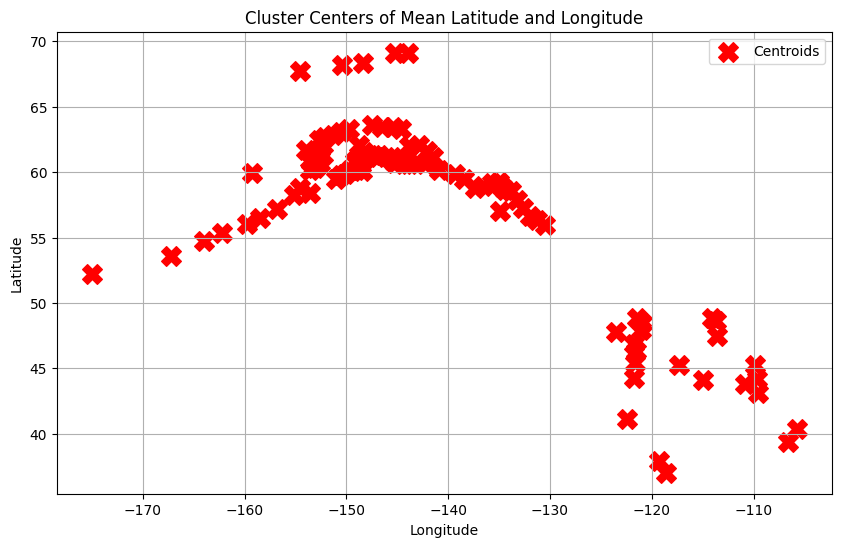

In [27]:
# Define the number of clusters
num_clusters = 100

# Initialize KMeans with the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0)

# Fit the KMeans model
cleaned_df_7[['lat', 'lng']] = cleaned_df_7[['lat', 'lng']].astype(float)
cleaned_df_7['cluster'] = kmeans.fit_predict(cleaned_df_7[['lat', 'lng']])

# Calculate the average coordinates for each cluster
cluster_means = cleaned_df_7.groupby('cluster')[['lat', 'lng']].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))

# Plot cluster centers
plt.scatter(cluster_means['lng'], cluster_means['lat'], c='red', s=200, marker='X', label='Centroids')

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cluster Centers of Mean Latitude and Longitude')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

cluster_means.to_csv('../Resources/100_cluster_means.csv')

In [28]:
# Convert cluster means to DataFrame
cluster_means_df = pd.DataFrame(cluster_means, columns=['lat', 'lng'])

# Create a column 'cluster_id' for index purposes starting at 1
cluster_means_df['cluster_id'] = range(1, len(cluster_means_df) + 1)

# Set 'cluster_id' as the index
cluster_means_df.set_index('cluster_id', inplace=True)

kdtree = KDTree(cluster_means_df[['lat', 'lng']].values)

In [29]:
data_coords = cleaned_df_7[['lat', 'lng']].values

distances, indices = kdtree.query(data_coords)

In [30]:
cleaned_df_7['closest_cluster_lat'] = cluster_means_df['lat'].iloc[indices].values
cleaned_df_7['closest_cluster_lng'] = cluster_means_df['lng'].iloc[indices].values

cleaned_df_7

,line_type,area,glac_id,anlys_time,db_area,min_elev,mean_elev,max_elev,src_date,glac_name,glac_stat,gone_date,release_dt,first_coordinate,lng,lat,cluster,closest_cluster_lat,closest_cluster_lng
0,dc,0,G223237E58554N,1148543303,495.176,0,0,0,933465600,Brady Glacier,e,e,1177210698,"-136.675873,58.385483",-136.675873,58.385483,27,58.955132,-136.541022
1,dc,0,G219795E60080N,1186713213,297.56,0,0,0,995500800,Marvine/Hayden Glacier,e,e,1192067393,"-140.10202,59.96069",-140.102020,59.960690,38,59.872209,-139.311547
2,dc,0,G222829E58804N,1148929281,162.882,0,0,0,933465600,Johns Hopkins Glacier,e,e,1150232094,"-137.260638,58.805875",-137.260638,58.805875,48,58.791778,-137.327807
3,dc,0,G223237E58554N,1148543303,495.176,0,0,0,933465600,Brady Glacier,e,e,1177210698,"-136.662581,58.464275",-136.662581,58.464275,27,58.955132,-136.541022
4,dc,0,G223237E58554N,1148543303,495.176,0,0,0,933465600,Brady Glacier,e,e,1177210698,"-136.652551,58.490007",-136.652551,58.490007,27,58.955132,-136.541022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69567,gb,0.015946,G254310E40448N,1676505600,0.015945,0,0,0,1602720000,None,e,e,1684195200,"-105.690397,40.449164",-105.690397,40.449164,81,40.338894,-105.771707
69568,gb,0.011637,G238806E48169N,1676505600,0.011638,0,0,0,1441756800,None,e,e,1684195200,"-121.193295,48.16877",-121.193295,48.168770,14,47.951310,-121.109655
69569,gb,0.024188,G246279E45318N,1676505600,0.024188,0,0,0,1378684800,None,e,e,1684195200,"-113.72218,45.31765",-113.722180,45.317650,30,44.069954,-114.970348
69570,gb,0.03978,G238224E44172N,1676505600,0.03978,0,0,0,1537142400,Linn Glacier,e,e,1684195200,"-121.777004,44.173283",-121.777004,44.173283,24,44.229202,-121.769272


In [31]:
# Filter the DataFrame
filtered_df = cleaned_df_7[cleaned_df_7['area'] != '0']

# Print the filtered DataFrame
filtered_df

,line_type,area,glac_id,anlys_time,db_area,min_elev,mean_elev,max_elev,src_date,glac_name,glac_stat,gone_date,release_dt,first_coordinate,lng,lat,cluster,closest_cluster_lat,closest_cluster_lng
14009,gb,0.777,G222822E58665N,1437004800,0.776922,2496,0,3879,1284508800,None,e,e,1437004800,"-137.171531,58.66963",-137.171531,58.669630,48,58.791778,-137.327807
14010,gb,0.033,G210987E61166N,1437004800,0.033314,1289,0,1404,1249257600,None,e,e,1437004800,"-149.01278,61.167452",-149.012780,61.167452,82,60.835090,-149.153620
14011,gb,8.838,G217968E60885N,1437004800,8.83774,1560,0,2410,1284249600,None,e,e,1437004800,"-141.998262,60.876832",-141.998262,60.876832,16,60.645740,-142.285727
14012,gb,0.192,G206922E60614N,1437004800,0.191698,1200,0,1636,1284249600,None,e,e,1437004800,"-153.074529,60.612969",-153.074529,60.612969,55,60.335547,-153.111089
14013,gb,0.059,G211115E62068N,1437004800,0.059431,2044,0,2316,1249257600,None,e,e,1437004800,"-148.886227,62.070393",-148.886227,62.070393,87,62.066800,-148.736702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69567,gb,0.015946,G254310E40448N,1676505600,0.015945,0,0,0,1602720000,None,e,e,1684195200,"-105.690397,40.449164",-105.690397,40.449164,81,40.338894,-105.771707
69568,gb,0.011637,G238806E48169N,1676505600,0.011638,0,0,0,1441756800,None,e,e,1684195200,"-121.193295,48.16877",-121.193295,48.168770,14,47.951310,-121.109655
69569,gb,0.024188,G246279E45318N,1676505600,0.024188,0,0,0,1378684800,None,e,e,1684195200,"-113.72218,45.31765",-113.722180,45.317650,30,44.069954,-114.970348
69570,gb,0.03978,G238224E44172N,1676505600,0.03978,0,0,0,1537142400,Linn Glacier,e,e,1684195200,"-121.777004,44.173283",-121.777004,44.173283,24,44.229202,-121.769272


In [32]:
# Filter the DataFrame
filtered_df_carrie = cleaned_df_7[cleaned_df_7['glac_name'] == 'Carrie Glacier']

# Print the filtered DataFrame
filtered_df_carrie

,line_type,area,glac_id,anlys_time,db_area,min_elev,mean_elev,max_elev,src_date,glac_name,glac_stat,gone_date,release_dt,first_coordinate,lng,lat,cluster,closest_cluster_lat,closest_cluster_lng
41523,gb,0.398177,G236365E47891N,1508803200,0.398473,0,0,0,1438387200,Carrie Glacier,e,e,1510045200,"-123.637759,47.893938",-123.637759,47.893938,1,47.776271,-123.499451
49186,gb,0.915,G236365E47891N,1154390400,0.915113,1556,0,2039,-830390400,Carrie Glacier,e,e,1456477200,"-123.62522,47.895612",-123.625220,47.895612,1,47.776271,-123.499451
66593,gb,0.107749,G236364E47890N,1676505600,0.10775,0,0,0,1441756800,Carrie Glacier,e,e,1684195200,"-123.629373,47.888791",-123.629373,47.888791,1,47.776271,-123.499451
69571,gb,0.391326,G236365E47891N,1676505600,0.391327,0,0,0,1441756800,Carrie Glacier,e,e,1684195200,"-123.63685,47.891797",-123.636850,47.891797,1,47.776271,-123.499451


In [33]:
cleaned_df_8 = cleaned_df_7.copy()

# cleaned_df_8 = cleaned_df_8[cleaned_df_8['area'] != '0']
cleaned_df_8 = cleaned_df_8[cleaned_df_8['glac_name'] != 'None']

cleaned_df_8

,line_type,area,glac_id,anlys_time,db_area,min_elev,mean_elev,max_elev,src_date,glac_name,glac_stat,gone_date,release_dt,first_coordinate,lng,lat,cluster,closest_cluster_lat,closest_cluster_lng
0,dc,0,G223237E58554N,1148543303,495.176,0,0,0,933465600,Brady Glacier,e,e,1177210698,"-136.675873,58.385483",-136.675873,58.385483,27,58.955132,-136.541022
1,dc,0,G219795E60080N,1186713213,297.56,0,0,0,995500800,Marvine/Hayden Glacier,e,e,1192067393,"-140.10202,59.96069",-140.102020,59.960690,38,59.872209,-139.311547
2,dc,0,G222829E58804N,1148929281,162.882,0,0,0,933465600,Johns Hopkins Glacier,e,e,1150232094,"-137.260638,58.805875",-137.260638,58.805875,48,58.791778,-137.327807
3,dc,0,G223237E58554N,1148543303,495.176,0,0,0,933465600,Brady Glacier,e,e,1177210698,"-136.662581,58.464275",-136.662581,58.464275,27,58.955132,-136.541022
4,dc,0,G223237E58554N,1148543303,495.176,0,0,0,933465600,Brady Glacier,e,e,1177210698,"-136.652551,58.490007",-136.652551,58.490007,27,58.955132,-136.541022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69563,gb,0.610026,G236663E47729N,1676505600,0.610024,0,0,0,1441756800,Eel Glacier,e,e,1684195200,"-123.337537,47.724574",-123.337537,47.724574,1,47.776271,-123.499451
69564,gb,0.01021,G238715E48917N,1676505600,0.010209,0,0,0,1441756800,WA,e,e,1684195200,"-121.284829,48.915118",-121.284829,48.915118,43,48.825866,-121.475250
69565,gb,2.18024,G238901E48124N,1676505600,2.18024,0,0,0,1441756800,Chocolate Glacier,e,e,1684195200,"-121.0775,48.117744",-121.077500,48.117744,14,47.951310,-121.109655
69570,gb,0.03978,G238224E44172N,1676505600,0.03978,0,0,0,1537142400,Linn Glacier,e,e,1684195200,"-121.777004,44.173283",-121.777004,44.173283,24,44.229202,-121.769272


In [34]:
counts = cleaned_df_8['glac_name'].value_counts()

cleaned_df_9 = cleaned_df_8[cleaned_df_8['glac_name'].isin(counts[counts >= 2].index)]

cleaned_df_9

,line_type,area,glac_id,anlys_time,db_area,min_elev,mean_elev,max_elev,src_date,glac_name,glac_stat,gone_date,release_dt,first_coordinate,lng,lat,cluster,closest_cluster_lat,closest_cluster_lng
0,dc,0,G223237E58554N,1148543303,495.176,0,0,0,933465600,Brady Glacier,e,e,1177210698,"-136.675873,58.385483",-136.675873,58.385483,27,58.955132,-136.541022
1,dc,0,G219795E60080N,1186713213,297.56,0,0,0,995500800,Marvine/Hayden Glacier,e,e,1192067393,"-140.10202,59.96069",-140.102020,59.960690,38,59.872209,-139.311547
2,dc,0,G222829E58804N,1148929281,162.882,0,0,0,933465600,Johns Hopkins Glacier,e,e,1150232094,"-137.260638,58.805875",-137.260638,58.805875,48,58.791778,-137.327807
3,dc,0,G223237E58554N,1148543303,495.176,0,0,0,933465600,Brady Glacier,e,e,1177210698,"-136.662581,58.464275",-136.662581,58.464275,27,58.955132,-136.541022
4,dc,0,G223237E58554N,1148543303,495.176,0,0,0,933465600,Brady Glacier,e,e,1177210698,"-136.652551,58.490007",-136.652551,58.490007,27,58.955132,-136.541022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69561,gb,0.01665,G236764E47851N,1676505600,0.016653,0,0,0,1441756800,WA,e,e,1684195200,"-123.235694,47.850382",-123.235694,47.850382,1,47.776271,-123.499451
69563,gb,0.610026,G236663E47729N,1676505600,0.610024,0,0,0,1441756800,Eel Glacier,e,e,1684195200,"-123.337537,47.724574",-123.337537,47.724574,1,47.776271,-123.499451
69564,gb,0.01021,G238715E48917N,1676505600,0.010209,0,0,0,1441756800,WA,e,e,1684195200,"-121.284829,48.915118",-121.284829,48.915118,43,48.825866,-121.475250
69565,gb,2.18024,G238901E48124N,1676505600,2.18024,0,0,0,1441756800,Chocolate Glacier,e,e,1684195200,"-121.0775,48.117744",-121.077500,48.117744,14,47.951310,-121.109655


In [35]:
cleaned_df_10 = cleaned_df_9.copy()

# Convert 'area' to numeric type
cleaned_df_10['area'] = pd.to_numeric(cleaned_df_10['area'])

# Sort by glacier name and time (Unix timestamps)
cleaned_df_11 = cleaned_df_10.sort_values(by=['glac_name', 'anlys_time'])

# Keep only the first occurrence for each timestamp within each glacier
cleaned_df_11 = cleaned_df_11.drop_duplicates(subset=['glac_name', 'anlys_time'], keep='first')

# Find the initial area value for each glac_name
initial_area = cleaned_df_11.groupby('glac_name')['area'].transform('first')

# Convert 'initial_area' to numeric type (if necessary)
initial_area = pd.to_numeric(initial_area)

# Set the initial value to 100
cleaned_df_11['percent_area'] = 100 + (cleaned_df_11['area'] - initial_area) / initial_area * 100



In [36]:
# Calculate counts for each glac_name
counts = cleaned_df_11['glac_name'].value_counts()

# Identify glac_name values that occur more than once
valid_glac_names = counts[counts > 1].index

# Filter DataFrame to keep only rows with glac_name in valid_glac_names
cleaned_df_11 = cleaned_df_11[cleaned_df_11['glac_name'].isin(valid_glac_names)]

cleaned_df_11

,line_type,area,glac_id,anlys_time,db_area,min_elev,mean_elev,max_elev,src_date,glac_name,glac_stat,gone_date,release_dt,first_coordinate,lng,lat,cluster,closest_cluster_lat,closest_cluster_lng,percent_area
42930,gb,0.000000,G207293E62414N,1262304000,0,0,0,0,1060387200,1,e,e,1299393082,"-152.706301,62.414146",-152.706301,62.414146,59,62.424539,-152.659773,NaN
42439,gb,0.000000,G213728E61274N,1263513600,0.177109,0,0,0,1184544000,1,e,e,1269471019,"-146.26203,61.271914",-146.262030,61.271914,25,61.151790,-146.092757,NaN
43053,gb,0.000000,G207492E62417N,1262304000,0,0,0,0,1060387200,10,e,e,1299393082,"-152.505837,62.413476",-152.505837,62.413476,59,62.424539,-152.659773,NaN
39209,gb,0.000000,G209419E63037N,1302825600,0.017771,0,0,0,-473385600,10,e,e,1305230445,"-150.578547,63.037453",-150.578547,63.037453,95,63.040598,-150.572604,NaN
43234,gb,0.000000,G209936E63244N,1262304000,0.299353,0,0,0,1060387200,100,e,e,1299393082,"-150.061016,63.24851",-150.061016,63.248510,47,63.329569,-149.779326,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43174,gb,0.000000,G208382E62801N,1262304000,379.897,0,0,0,1060387200,Yentna Glacier,e,e,1299393082,"-151.441881,62.943456",-151.441881,62.943456,12,62.869148,-151.307234,NaN
38883,gb,0.000000,G208382E62801N,1302825600,392.112,0,0,0,-536457600,Yentna Glacier,e,e,1305230445,"-151.34927,62.901418",-151.349270,62.901418,12,62.869148,-151.307234,NaN
44809,gb,211.148000,G208382E62801N,1437004800,387.383,263,0,3393,1284249600,Yentna Glacier,e,e,1437004800,"-151.540907,62.932107",-151.540907,62.932107,12,62.869148,-151.307234,inf
49247,gb,3.116000,G238278E45362N,1154390400,3.11621,1803,0,3142,-420076800,Zigzag Glacier,e,e,1456477200,"-121.70245,45.370953",-121.702450,45.370953,90,45.380351,-121.694008,100.000000


In [38]:
rows_with_zero_area = cleaned_df_11[cleaned_df_11['area'] == 0]

rows_with_zero_area

,line_type,area,glac_id,anlys_time,db_area,min_elev,mean_elev,max_elev,src_date,glac_name,glac_stat,gone_date,release_dt,first_coordinate,lng,lat,cluster,closest_cluster_lat,closest_cluster_lng,percent_area
42930,gb,0.0,G207293E62414N,1262304000,0,0,0,0,1060387200,1,e,e,1299393082,"-152.706301,62.414146",-152.706301,62.414146,59,62.424539,-152.659773,NaN
42439,gb,0.0,G213728E61274N,1263513600,0.177109,0,0,0,1184544000,1,e,e,1269471019,"-146.26203,61.271914",-146.262030,61.271914,25,61.151790,-146.092757,NaN
43053,gb,0.0,G207492E62417N,1262304000,0,0,0,0,1060387200,10,e,e,1299393082,"-152.505837,62.413476",-152.505837,62.413476,59,62.424539,-152.659773,NaN
39209,gb,0.0,G209419E63037N,1302825600,0.017771,0,0,0,-473385600,10,e,e,1305230445,"-150.578547,63.037453",-150.578547,63.037453,95,63.040598,-150.572604,NaN
43234,gb,0.0,G209936E63244N,1262304000,0.299353,0,0,0,1060387200,100,e,e,1299393082,"-150.061016,63.24851",-150.061016,63.248510,47,63.329569,-149.779326,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,dc,0.0,G212622E61302N,1417392000,152.245,0,0,3623,1565222400,Yale Glacier,e,e,1633078800,"-147.368866,61.289851",-147.368866,61.289851,58,61.297452,-147.428321,NaN
58969,gb,0.0,G209221E59477N,1662681600,33.8425,0,0,0,1472601600,Yalik Glacier,e,e,1666515600,"-150.839498,59.582783",-150.839498,59.582783,9,59.456376,-150.994910,0.0
42156,gb,0.0,G212445E63584N,1272672000,91.1037,0,0,0,1121990400,Yanert Glacier,e,e,1274467072,"-147.821694,63.591494",-147.821694,63.591494,53,63.622686,-147.516281,NaN
43174,gb,0.0,G208382E62801N,1262304000,379.897,0,0,0,1060387200,Yentna Glacier,e,e,1299393082,"-151.441881,62.943456",-151.441881,62.943456,12,62.869148,-151.307234,NaN
